# WMT of tendency terms
## CM2.6
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

In [12]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [13]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.936fd6552f2f4fa7a0075e84de1dcbed/status,


In [68]:
cluster.close()
client.close()

In [8]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated

In [17]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [31]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

natl_ocean = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/natl_ocean.zarr'))
npac_ocean = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/npac_ocean.zarr'))
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))
mask = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/mask.zarr'))

tend = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tendencies_outliers_rm.zarr'))

In [11]:
natl_ocean

<xarray.Dataset>
Dimensions:         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    lat             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    lon             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    st_ocean        float64 ...
  * time            (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    NATL_cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [6]:
res = tend.rho_lap + tend.cabbeling - tend.sss - tend.sst

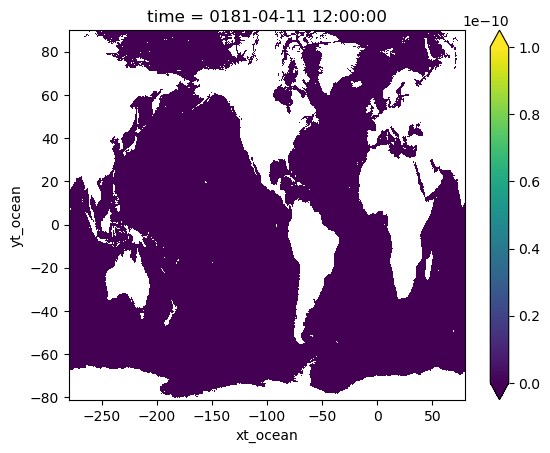

In [7]:
res.isel(time=100).plot(robust=True, vmin=1e-10);

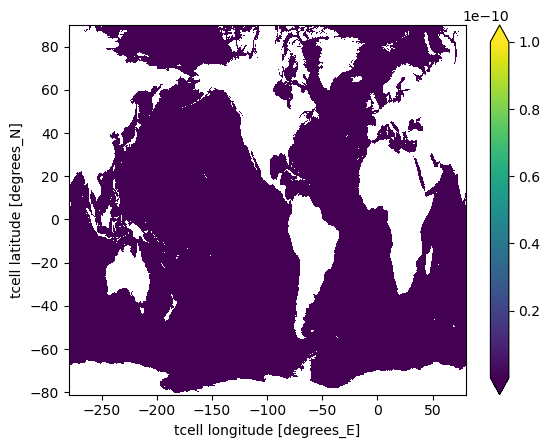

In [20]:
res.mean('time').plot(robust=True, vmin=1e-10);

In [21]:
def open_surf_tends(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf/' + basin_file + '_tends.zarr'))
    return ds

In [22]:
def open_histograms(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/' + 
                                              basin_file + '.zarr'))
    return ds

In [23]:
surf_names = list(['natl_ocean_surf', 'satl_ocean_surf', 'npac_ocean_surf', 
                   'spac_ocean_surf', 'arc_ocean_surf', 'south_ocean_surf', 'ind_ocean_surf'])
surf_hist_names = list(['natl_hist_surf', 'satl_hist_surf', 'npac_hist_surf', 
                   'spac_hist_surf', 'arc_hist_surf', 'south_hist_surf', 'ind_hist_surf'])
hist_names = list(['natl_hist', 'satl_hist', 'npac_hist', 
             'spac_hist', 'arc_hist', 'south_hist', 'ind_hist'])
surf_tends = list()
surf_hist = list()
hist = list()

In [24]:
#load in basin surface tendencies
for name in surf_names:
    surf_tends.append(open_surf_tends(name))
    for ds in surf_tends:
        globals()[name] = ds

In [25]:
#load in basin surface histograms
for name in surf_hist_names:
    surf_hist.append(open_histograms(name))
    for ds in surf_hist:
        globals()[name] = ds

In [26]:
#load in basin mixing histograms
for name in hist_names:
    hist.append(open_histograms(name))
    for ds in hist:
        globals()[name] = ds

In [27]:
natl_hist

<xarray.Dataset>
Dimensions:          (time: 240, rho0_bin: 199)
Coordinates:
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
  * time             (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
Data variables:
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

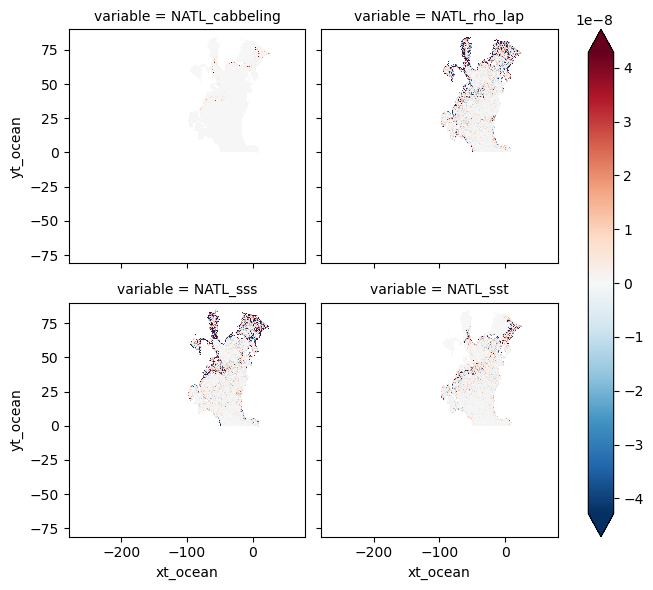

In [37]:
natl_ocean.isel(time=20).to_array().plot(col='variable', col_wrap=2, robust=True)

# Create histograms

In [25]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

In [46]:
#mask = mask.mask
delta_rho = 0.1
rho = rho.rho_test
rho_bins = np.arange(1015, 1035, delta_rho)
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

In [47]:
from xhistogram.xarray import histogram
def histogram_function(ds, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[variable].fillna(0.)*(weights).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [50]:
#mixing components
natl_hist = xr.merge([histogram_function(natl_ocean, var).rename('OMEGA_' + var) for var in list(natl_ocean.data_vars)])
npac_hist = xr.merge([histogram_function(npac_ocean, var).rename('OMEGA_' + var) for var in list(npac_ocean.data_vars)])

In [51]:
natl_hist

<xarray.Dataset>
Dimensions:               (time: 7305, rho0_bin: 199)
Coordinates:
  * time                  (time) object 0181-01-01 12:00:00 ... 0200-12-31 12...
  * rho0_bin              (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_NATL_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_NATL_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_NATL_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_NATL_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

# Plot ann mean

In [52]:
residual = ((natl_hist.OMEGA_NATL_rho_lap - natl_hist.OMEGA_NATL_sss - 
             natl_hist.OMEGA_NATL_sst + natl_hist.OMEGA_NATL_cabbeling)/1e6).isel(time=200)

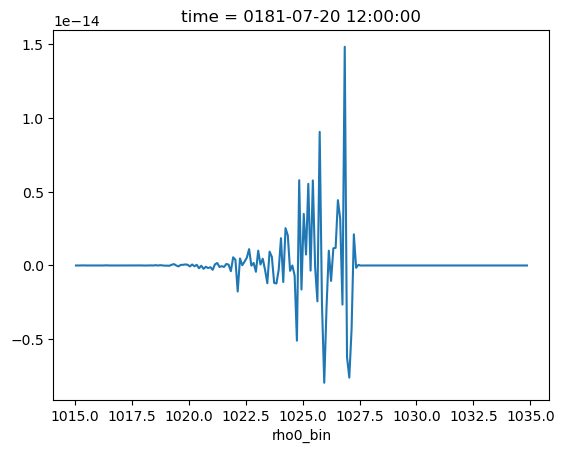

In [53]:
residual.plot()

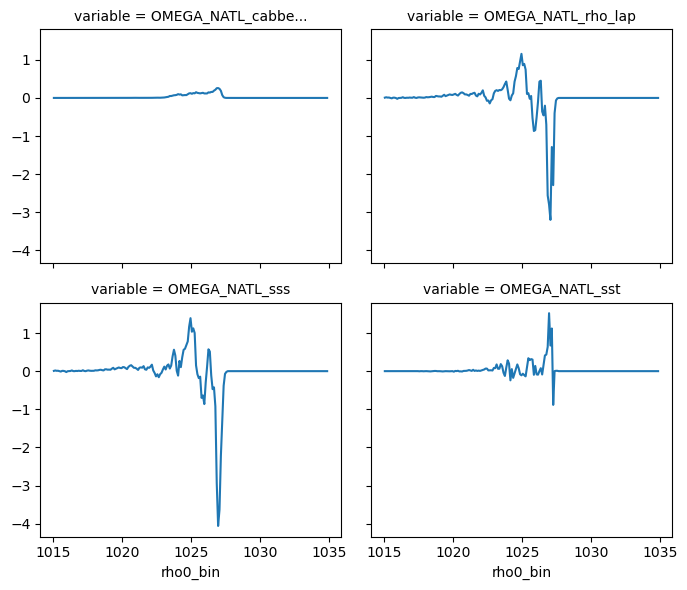

In [54]:
(natl_hist.isel(time=200)/1e6).to_array().plot(col='variable', col_wrap=2)

In [57]:
residual = ((npac_hist.OMEGA_NPAC_rho_lap - npac_hist.OMEGA_NPAC_sss - 
             npac_hist.OMEGA_NPAC_sst + npac_hist.OMEGA_NPAC_cabbeling)/1e6).isel(time=200)

In [55]:
def ann_mean2(ds):
    fig = plt.figure(figsize=(12,5))
    line_colors=['blue', 'k', 'orange', 
                 'green'] #order of cab, rho, sss, sst
    for (i,j) in zip(list(ds.data_vars), line_colors):
        (ds[i].mean('time')/1e6).plot(label=f'{i}', color=j)
        residual.plot(color='grey', linestyle='dashed')
    plt.legend()
    #plt.ylim(-20,10)
    plt.ylabel(r'Transformation (Sv)', fontsize=16)
    plt.grid()
    plt.title('Annual Mean Transformation Terms', fontsize=20);

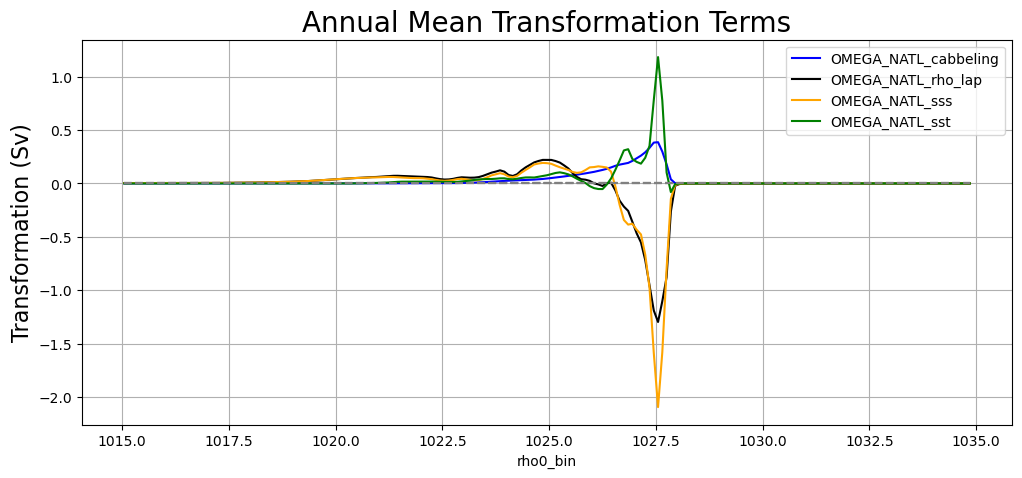

In [56]:
ann_mean2(natl_hist)

In [ ]:
ann_mean2(npac_hist)

In [76]:
def ann_mean(mix, surf, basin_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_colors=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    for (i,j) in zip(list(mix.data_vars), line_colors):
        (mix[i].mean('time')/1e6).plot(label=f'{i}', color=j, ax=ax0)
    
    #plotting mixing residual
    ((mix.OMEGA_rho_lap + mix.OMEGA_cabbeling -
      mix.OMEGA_sss - mix.OMEGA_sst).mean('time')/1e6).plot(label='residual', color='grey', 
                                                                linestyle='dashed', ax=ax0)
    for (i,j) in zip(list(surf.data_vars), line_surf):
        (surf[i].mean('time')/1e6).plot(label=f'{i}', color=j, ax=ax1)
    ax0.legend()
    ax0.set_xlim(1016,1030)
    ax0.set_ylabel(r'Transformation (Sv)', fontsize=16)
    ax0.grid()
    ax0.set_title('Mixing terms')
    ax0.set_xlabel('')
    
    ax1.legend()
    ax1.set_xlim(1016,1030)
    ax1.set_ylabel('')
    ax1.grid()
    ax1.set_title('Surface terms')
    ax1.set_xlabel('')
    
    fig.supxlabel('Rho bins', fontsize=16)
    plt.suptitle('Annual Mean Transformation', fontsize=20)
    plt.savefig(f'{basin_title}_ann_mean_hist_fig.pdf');

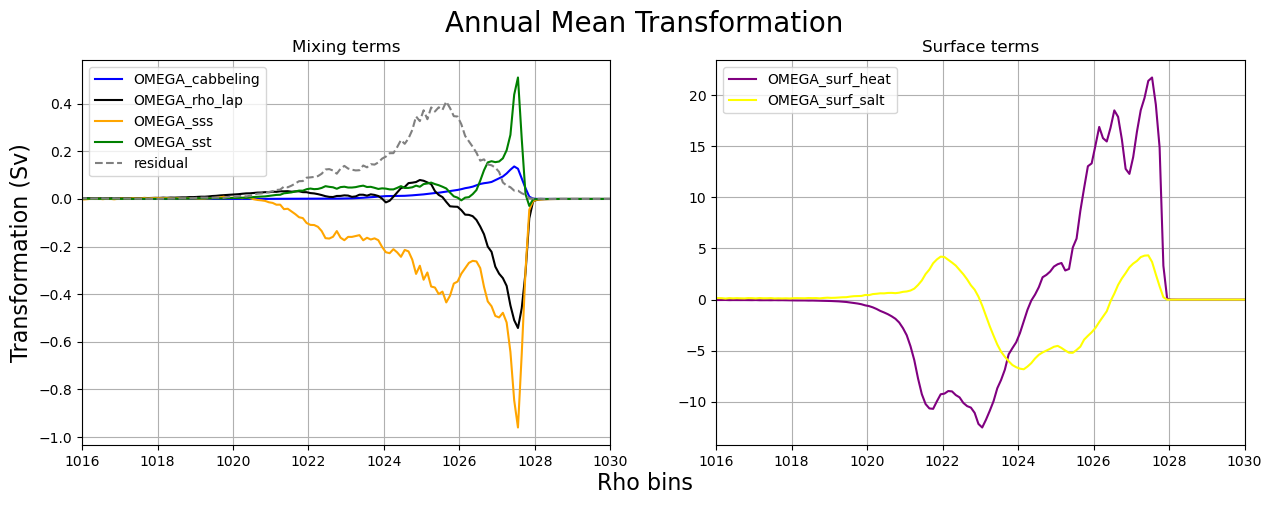

In [80]:
ann_mean(natl_hist, natl_hist_surf, 'NATL')

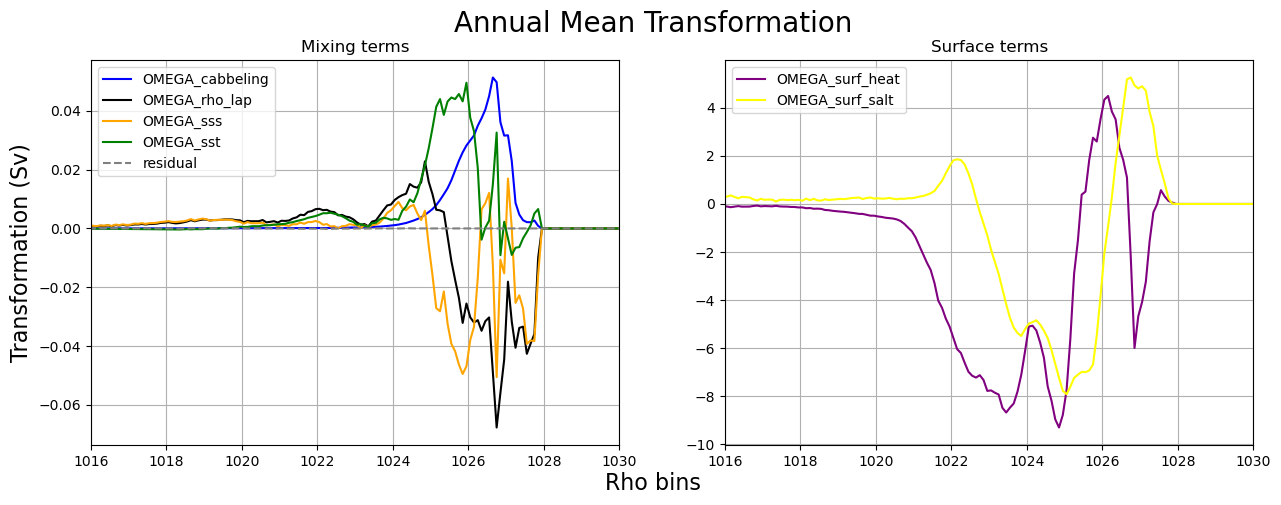

In [81]:
ann_mean(satl_hist, satl_hist_surf, 'SATL')

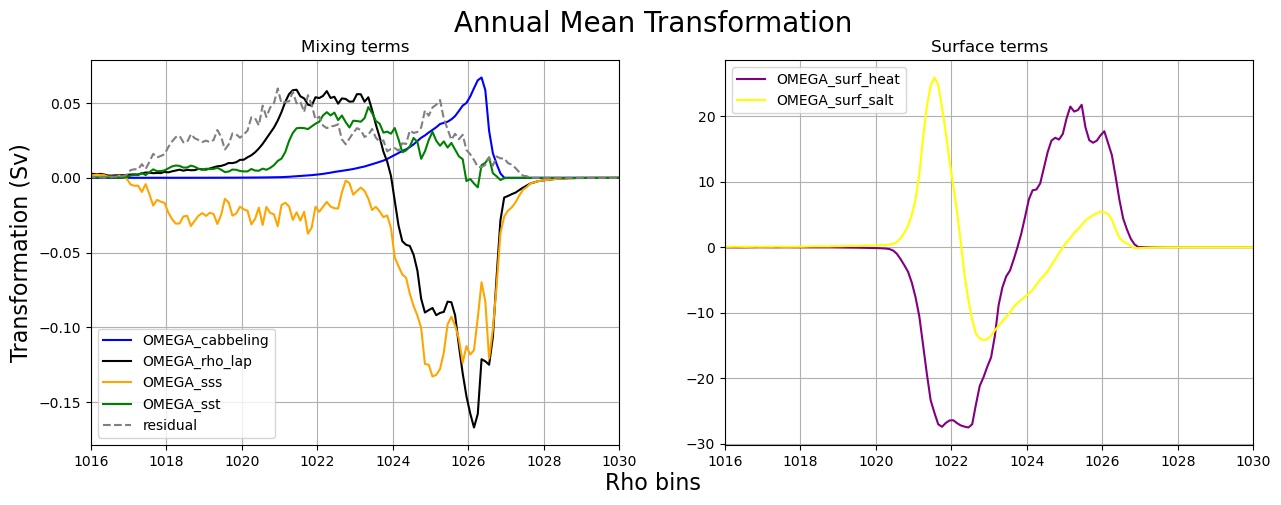

In [82]:
ann_mean(npac_hist, npac_hist_surf, 'NPAC')

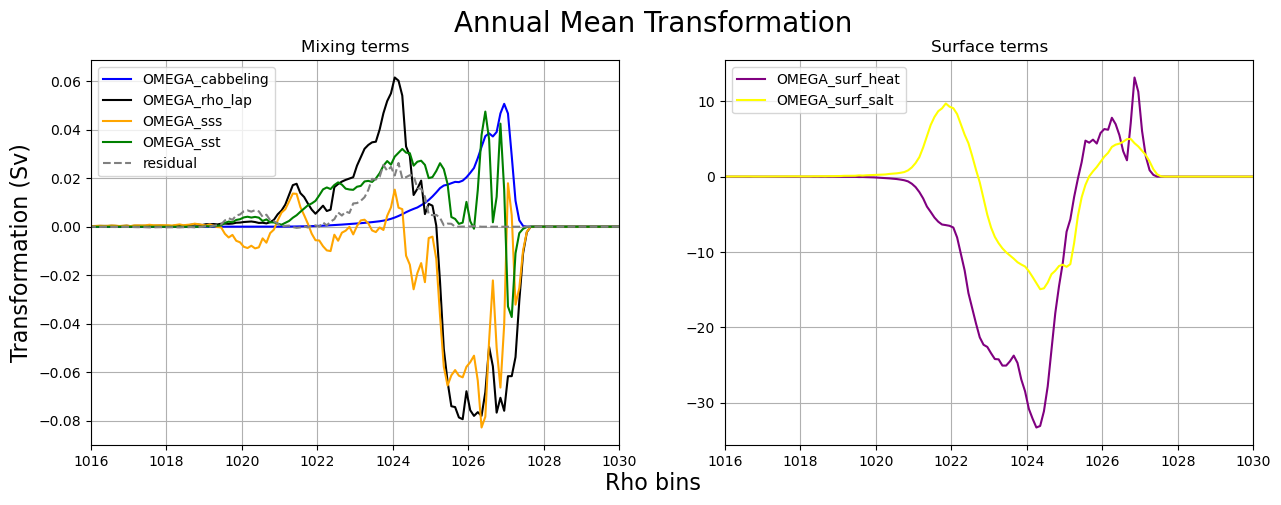

In [83]:
ann_mean(spac_hist, spac_hist_surf, 'SPAC')

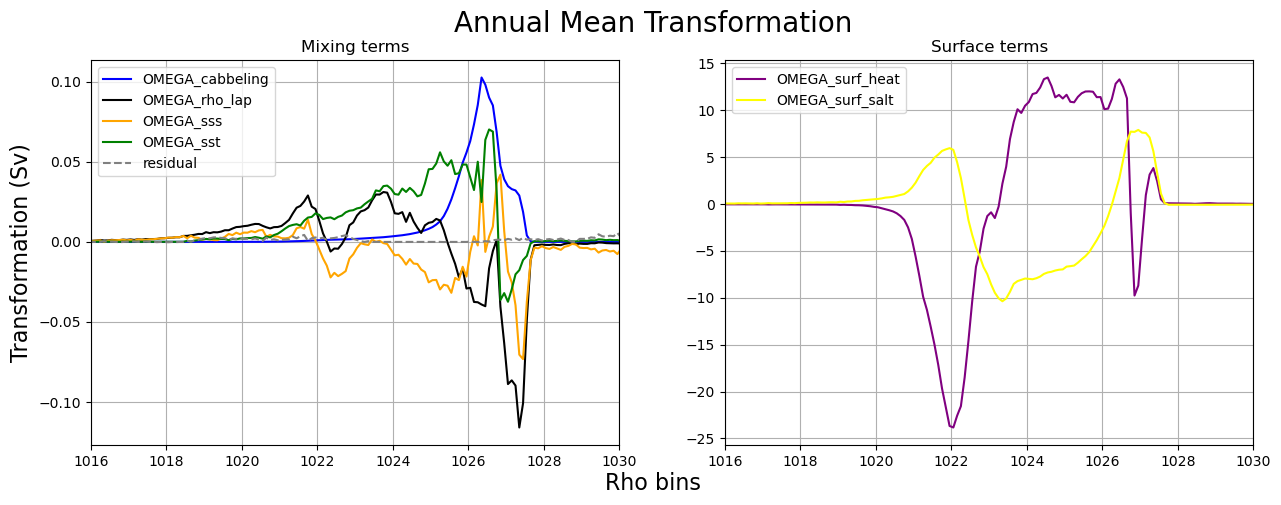

In [84]:
ann_mean(ind_hist, ind_hist_surf, 'IND')

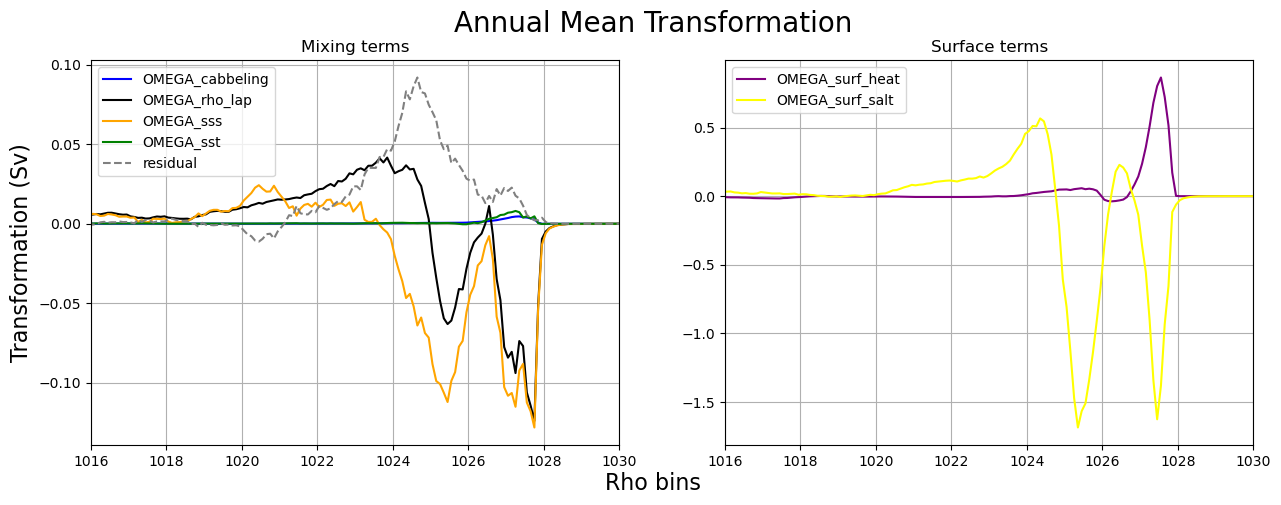

In [85]:
ann_mean(arc_hist, arc_hist_surf, 'ARC')

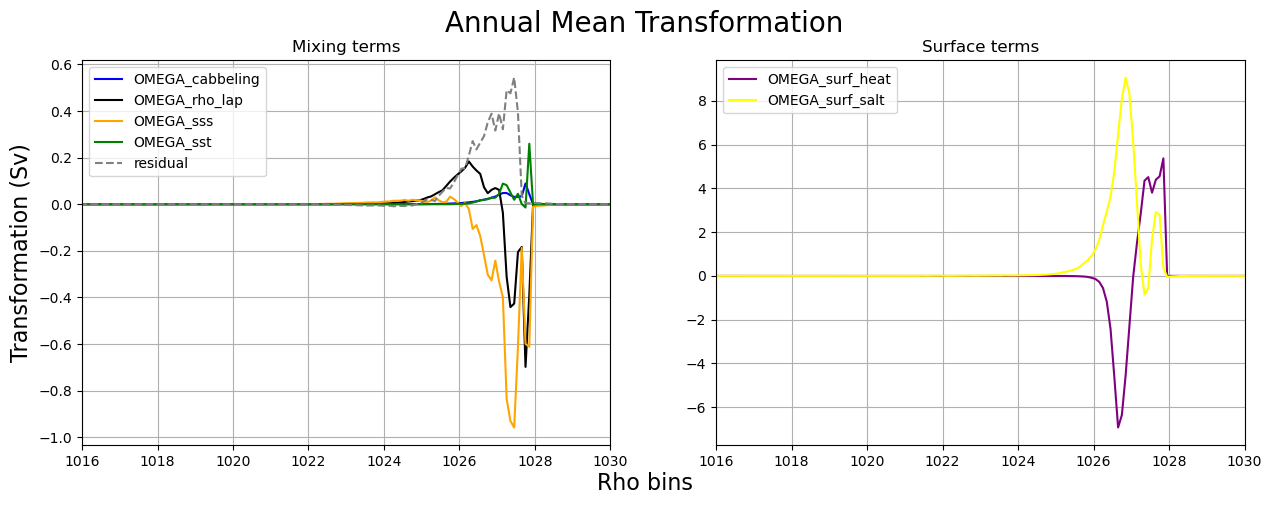

In [86]:
ann_mean(south_hist, south_hist_surf, 'SOUTH')

[Back to top](#top)